In [146]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import homogeneity_score, completeness_score, adjusted_rand_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA, TruncatedSVD


import warnings
warnings.filterwarnings('ignore')


In [2]:
# Задание 4.1

# Так как изначально данные были представлены для решения задачи классификации, то они находятся в разных файлах (обучающая и тестовая
# выборки в соотношении 70/30). Соедините признаки так, чтобы сначала шла обучающая выборка, а затем - тестовая, и отдельно соедините
# значения целевых переменных (разумеется, в том же порядке).
# Какая размерность получилась у набора данных с признаками?

X_train = np.loadtxt('./data/train.txt')
X_test = np.loadtxt('./data/test.txt')

y_train = np.loadtxt('./data/train_labels.txt')
y_test = np.loadtxt('./data/test_labels.txt')

X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))

X.shape


(10299, 561)

In [50]:
# Задание 4.2

# Теперь найдите число различных активностей, то есть на сколько кластеров в идеале должны разделиться наблюдения.
activities = pd.Series(y).nunique() # 1 вариант
np.unique(y).shape # 2 вариант

(6,)

In [16]:
# Задание 4.3

# Далее необходимо отмасштабировать признаки. Будем использовать для этого алгоритм StandardScaler. Примените его ко всем значениям
# признаков и впишите в качестве ответа значение первого признака для первого объекта, предварительно округлив его до двух знаков после
# точки-разделителя.
scalelr = StandardScaler()
X_norm = scalelr.fit_transform(X)
round(X_norm[0][0], 2)

0.21

,cluster,silhouette_score,calinski_harabasz_score,davies_bouldin_score
0,2,0.393732,7880.813904,1.070744
1,3,0.315484,5034.475257,1.786516
2,4,0.150529,3696.338198,2.340930
3,5,0.127237,3027.076172,2.431375
4,6,0.110969,2556.773574,2.367036
5,7,0.085419,2216.563937,2.681980
6,8,0.076183,1974.971496,2.611226
7,9,0.076488,1790.953173,2.581888


''

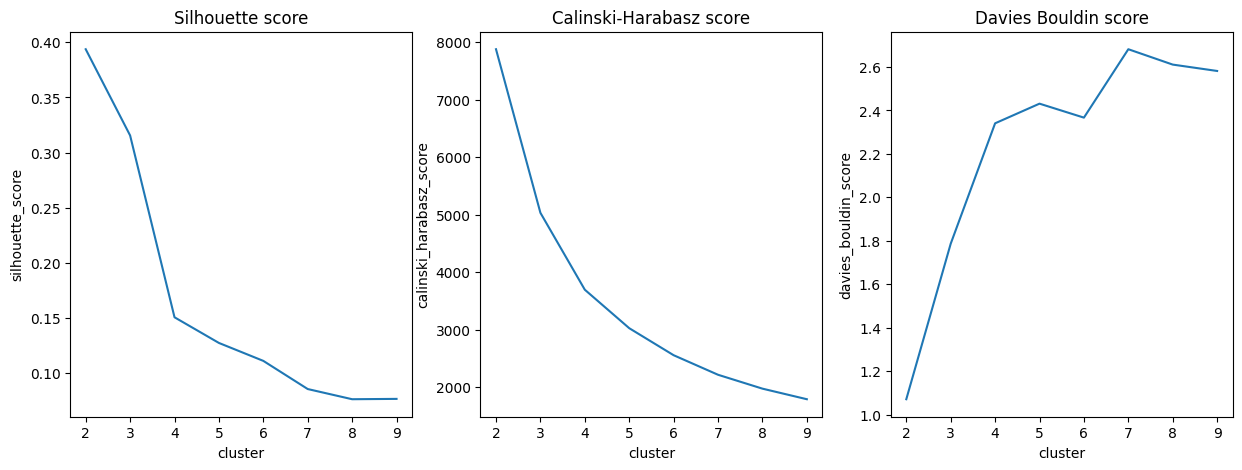

In [48]:
# Задание 4.4

# Пора переходить к кластеризации. Для начала определите оптимальное количество кластеров, используя внутренние меры кластеризации.
# Используйте все известные вам коэффициенты, реализуемые в библиотеке sklearn: коэффициент силуэта, индекс Калински - Харабаса и индекс
# Дэвиса - Болдина. В качестве алгоритма возьмите k-means++, в качестве значения параметра random state - Число 42.
# Выведите оптимальное количество кластеров для каждой метрики, перебирая значения от 2 до 9 включительно. Также введите значение
# каждой метрики, округлённое до двух знаков после точки-разделителя.

initial_clusters = range(2, 10)
silhouette = []
calinski = []
davies = []

for cluster in initial_clusters:
    km_base = KMeans(n_clusters=cluster, random_state=42)
    km_base.fit_predict(X_norm)

    silhouette.append((cluster, silhouette_score(X_norm, km_base.labels_)))
    calinski.append((cluster, calinski_harabasz_score(X_norm, km_base.labels_)))
    davies.append((cluster, davies_bouldin_score(X_norm, km_base.labels_)))

silhouette_df = pd.DataFrame(silhouette, columns=['cluster', 'silhouette_score'])
calinski_df = pd.DataFrame(calinski, columns=['cluster', 'calinski_harabasz_score'])
davies_df = pd.DataFrame(davies, columns=['cluster', 'davies_bouldin_score'])
optimal_cluster = pd.merge(left=silhouette_df, right=calinski_df)
optimal_cluster = pd.merge(left=optimal_cluster, right=davies_df)
display(optimal_cluster)

fig, axes = plt.subplots(1,3, figsize=(15,5))
sns.lineplot(data=optimal_cluster, x='cluster', y='silhouette_score', ax=axes[0])
sns.lineplot(data=optimal_cluster, x='cluster', y='calinski_harabasz_score', ax=axes[1])
sns.lineplot(data=optimal_cluster, x='cluster', y='davies_bouldin_score', ax=axes[2])

axes[0].set_title('Silhouette score')
axes[1].set_title('Calinski-Harabasz score')
axes[2].set_title('Davies Bouldin score')
;

In [55]:
# Задание 4.5

# Теперь давайте оценим качество кластеризации с точки зрения внешних мер. Реализуйте кластеризацию с помощью классической версии
# алгоритма k-means . Пусть количество кластеров будет соответствовать количеству активностей. Задайте следующие значения параметров:
# random state=42, init='random'.
# В качестве ответов введите значения получившихся мер, предварительно округлив их до двух знаков после точки-разделителя.
km_base = KMeans(n_clusters=activities, init='random', random_state=42)
km_base.fit_predict(X_norm)

print(homogeneity_score(y, km_base.labels_).round(2))
print(completeness_score(y, km_base.labels_).round(2))
print(round(adjusted_rand_score(y, km_base.labels_),2))

0.54
0.58
0.42


In [71]:
# Задание 4.6

# Выясните, к каким кластерам были преимущественно отнесены различные активности (т. е. в какой кластер попало большинство наблюдений с
# этой активностью). Нумерацию кластеров начинайте с 1.
activ_type = pd.Series(y)
cluster_check = pd.concat([activ_type, pd.Series(km_base.labels_)], axis=1)
cluster_check.value_counts()

0    1
6.0  0    1556
5.0  1    1346
2.0  2    1242
4.0  1    1238
1.0  2     903
3.0  4     889
1.0  4     741
5.0  5     560
4.0  5     447
6.0  5     329
3.0  2     321
2.0  4     295
3.0  3     196
4.0  0      91
1.0  3      78
6.0  1      54
2.0  3       5
6.0  2       5
2.0  5       2
4.0  2       1
dtype: int64

In [74]:
# Эталонное решение
#создаём таблицу сопряжённости
ct = pd.crosstab(y, km_base.labels_)
#определяем название активностей
ct.index = ['ходьба', 'подъём', 
            'спуск', 'сидение', 'стояние', 'лежание']
ct.columns = list(range(1,7))
display(ct)

,1,2,3,4,5,6
ходьба,0,0,903,78,741,0
подъём,0,0,1242,5,295,2
спуск,0,0,321,196,889,0
сидение,91,1238,1,0,0,447
стояние,0,1346,0,0,0,560
лежание,1556,54,5,0,0,329


In [76]:
# Задание 4.7

# Теперь попробуйте реализовать алгоритм k-means для двух кластеров (для того числа активностей, которое является оптимальным с точки
# зрения внутренних мер) и снова посмотреть, как алгоритм разобьёт активности по кластерам. Как и в предыдущем задании, нумерацию
# кластеров начинайте с 1.
km_prop = KMeans(n_clusters=2, init='random', random_state=42)
km_prop.fit_predict(X_norm)

ct = pd.crosstab(y, km_prop.labels_)
ct.index = ct.index = ['ходьба', 'подъём', 
            'спуск', 'сидение', 'стояние', 'лежание']
ct.columns = [1,2]
ct

,1,2
ходьба,1722,0
подъём,1536,8
спуск,1406,0
сидение,3,1774
стояние,0,1906
лежание,12,1932


In [78]:
# Задание 4.8

# Вычислите значение полноты для разбиения на два кластера алгоритмом k-means. Ответ округлите до двух знаков после точки-
# разделителя.
completeness_score(y, km_prop.labels_).round(2)

0.98

In [81]:
# Задание 4.10

# Давайте сравним полученный результат с агломеративной иерархической кластеризацией. Реализуйте её также для двух кластеров и
# вычислите значение полноты.

agglo_clust = AgglomerativeClustering(n_clusters=2)
agglo_clust.fit_predict(X_norm)

completeness_score(y, agglo_clust.labels_).round(2)


1.0

---

In [90]:
# Задание 5.1

# Найдите матрицу ковариаций для векторов (3, 4, 1) и (1, 6, 2). В качестве ответа укажите сумму всех значений матрицы, округлённую до двух
# знаков после точки-разделителя.
a = np.array([3, 4, 1])
b = np.array([1, 6, 2])

round(np.cov(a,b).sum(),2)


14.33

In [109]:
# Задание 5.5

# Дана матрица признаков
# Какое минимальное количество главных компонент надо выделить, чтобы сохранить информацию о как минимум 90 % разброса данных?

A = np.matrix([
    [8, 7, 2, 9],
    [1, 3, 6, 3],
    [7, 2, 0, 3],
    [10, 3, 1, 1],
    [8, 1, 3, 4]
])

df = pd.DataFrame(A)
scaller = StandardScaler()
A_std = scaller.fit_transform(df)
#df_std  = (df - df.mean()) / (df.std())

pca = PCA(n_components=0.9)
prin_comp = pca.fit_transform(A_std)

display(prin_comp)

array([[-1.80165871,  1.97185427,  0.01476842],
       [ 2.3304418 ,  1.13731957, -0.27299129],
       [-0.33058187, -1.07271253, -0.05894919],
       [-0.56338656, -1.39054159, -0.56805924],
       [ 0.36518535, -0.64591972,  0.8852313 ]])

In [157]:
# создаём объект класса TruncatedSVD
# n_components — размерность нового пространства, n_iter — количество итераций
#A = np.matrix([[-1, 1, 0],[-1, -1, 1]])
A = np.array([[-1, 1, 0], [-1, -1, 1]]).T

svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
# обучаем модель на данных X
svd.fit(A)
# применяем уменьшение размерности к матрице X
transformed = svd.transform(A)

transformed

array([[ 1.,  1.],
       [ 1., -1.],
       [-1.,  0.]])

In [162]:
# импортируем класс TSNE из модуля manifold библиотеки sklearn
from sklearn.manifold import TSNE
# создаём объект класса TSNE
# n_components — размерность нового пространства
tsne = TSNE(n_components=2, perplexity=30, n_iter=500, random_state=42)
# обучаем модель на данных X и применяем к матрице X уменьшение размерности
tsne.fit_transform(X)


array([[-19.350155 , -35.30527  ],
       [-19.653883 ,  -5.1900606],
       [-20.152666 , -22.464697 ],
       ...,
       [ 13.928527 , -16.843653 ],
       [ 13.828104 , -16.859516 ],
       [ 13.80447  , -16.702316 ]], dtype=float32)